In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Intelligent-Data-Analysis-Project

by Lucas Hoeft

In [3]:
# https://www.kaggle.com/datasets/thedevastator/childhood-allergies-prevalence-diagnosis-and-tre
allergies = pd.read_csv('data/childhood-alergies/food-allergy-analysis-Zenodo.csv', sep=",", na_values="NA")

In [4]:
allergies.columns

Index(['SUBJECT_ID', 'BIRTH_YEAR', 'GENDER_FACTOR', 'RACE_FACTOR',
       'ETHNICITY_FACTOR', 'PAYER_FACTOR', 'ATOPIC_MARCH_COHORT',
       'AGE_START_YEARS', 'AGE_END_YEARS', 'SHELLFISH_ALG_START',
       'SHELLFISH_ALG_END', 'FISH_ALG_START', 'FISH_ALG_END', 'MILK_ALG_START',
       'MILK_ALG_END', 'SOY_ALG_START', 'SOY_ALG_END', 'EGG_ALG_START',
       'EGG_ALG_END', 'WHEAT_ALG_START', 'WHEAT_ALG_END', 'PEANUT_ALG_START',
       'PEANUT_ALG_END', 'SESAME_ALG_START', 'SESAME_ALG_END',
       'TREENUT_ALG_START', 'TREENUT_ALG_END', 'WALNUT_ALG_START',
       'WALNUT_ALG_END', 'PECAN_ALG_START', 'PECAN_ALG_END',
       'PISTACH_ALG_START', 'PISTACH_ALG_END', 'ALMOND_ALG_START',
       'ALMOND_ALG_END', 'BRAZIL_ALG_START', 'BRAZIL_ALG_END',
       'HAZELNUT_ALG_START', 'HAZELNUT_ALG_END', 'CASHEW_ALG_START',
       'CASHEW_ALG_END', 'ATOPIC_DERM_START', 'ATOPIC_DERM_END',
       'ALLERGIC_RHINITIS_START', 'ALLERGIC_RHINITIS_END', 'ASTHMA_START',
       'ASTHMA_END', 'FIRST_ASTHMARX', 'L

In [5]:
wildfires = pd.read_csv('data/us-wildfires/data.csv', sep=",", na_values="NA")

/var/folders/bh/vwy58769197gtfy7_tb12xqw0000gn/T/ipykernel_71454/2529558485.py:1: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,26,27,36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfires = pd.read_csv('data/us-wildfires/data.csv', sep=",", na_values="NA")


In [6]:
gb = wildfires.groupby([(wildfires["DISCOVERY_DATE"]),(wildfires["DISCOVERY_DATE"])]).sum()

In [7]:
wildfires["DISCOVERY_DATE_YEAR"] = 0
wildfires["DISCOVERY_DATE_YEAR"] = pd.DatetimeIndex(wildfires['DISCOVERY_DATE']).year

In [8]:
gb

,,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE
DISCOVERY_DATE,DISCOVERY_DATE,,,,,,,,,,,
1/1/1992,1/1/1992,112048447,511875225,256968,129,51964.0,70.0,75488.0,1504.4900,4533.564347,-11655.262288,4203846.0
1/1/1993,1/1/1993,56121641,361064236,117587,59,38368.0,323.0,37691.0,705.4700,1995.683947,-5074.723908,1173958.0
1/1/1994,1/1/1994,60301353,226664846,155532,78,63284.0,83.0,79654.0,2239.1300,2651.802736,-7390.668637,2040825.0
1/1/1995,1/1/1995,14118831,29732950,37905,19,12214.0,41.0,10647.0,36.7200,708.422374,-1886.448523,412030.0
1/1/1996,1/1/1996,23454761,81000827,53892,27,12820.0,19.0,14280.0,26.7700,944.402915,-2993.834150,133462.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9/9/2016,9/9/2016,349274389,72011590369,362880,45540,231648.0,36994.0,224335.0,548.8100,6769.377438,-17728.338295,3912703.0
9/9/2017,9/9/2017,552010283,112027653081,564760,70560,316969.0,49904.0,279054.0,14054.6100,10952.079203,-29649.532467,7463586.0
9/9/2018,9/9/2018,310422029,59651640613,300682,37548,195327.0,29673.0,174322.0,774.5367,5909.460289,-16121.426084,3196894.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DISCOVERY_DATE_YEAR', ylabel='count'>

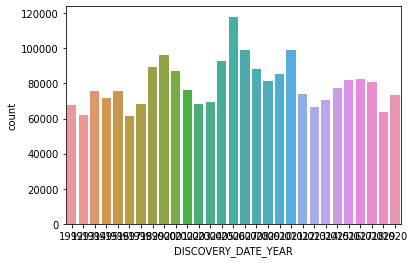

In [9]:
sns.countplot(wildfires["DISCOVERY_DATE_YEAR"])

In [10]:
wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020].shape

(73262, 40)

In [11]:
wildfires['DISCOVERY_DATE'] = pd.to_datetime(wildfires['DISCOVERY_DATE'])
wildfires['DISCOVERY_DATE']

0         2005-02-02
1         2004-05-12
2         2004-05-31
3         2004-06-28
4         2004-06-28
             ...    
2303561   2020-06-05
2303562   2020-07-11
2303563   2020-08-27
2303564   2020-08-17
2303565   2020-11-20
Name: DISCOVERY_DATE, Length: 2303566, dtype: datetime64[ns]

In [12]:
wildfires.dtypes

OBJECTID                                  int64
Shape                                    object
FOD_ID                                    int64
FPA_ID                                   object
SOURCE_SYSTEM_TYPE                       object
SOURCE_SYSTEM                            object
NWCG_REPORTING_AGENCY                    object
NWCG_REPORTING_UNIT_ID                   object
NWCG_REPORTING_UNIT_NAME                 object
SOURCE_REPORTING_UNIT                    object
SOURCE_REPORTING_UNIT_NAME               object
LOCAL_FIRE_REPORT_ID                     object
LOCAL_INCIDENT_ID                        object
FIRE_CODE                                object
FIRE_NAME                                object
ICS_209_PLUS_INCIDENT_JOIN_ID            object
ICS_209_PLUS_COMPLEX_JOIN_ID             object
MTBS_ID                                  object
MTBS_FIRE_NAME                           object
COMPLEX_NAME                             object
FIRE_YEAR                               

array([[<AxesSubplot:title={'center':'OBJECTID'}>,
        <AxesSubplot:title={'center':'FOD_ID'}>,
        <AxesSubplot:title={'center':'FIRE_YEAR'}>,
        <AxesSubplot:title={'center':'DISCOVERY_DATE'}>],
       [<AxesSubplot:title={'center':'DISCOVERY_DOY'}>,
        <AxesSubplot:title={'center':'DISCOVERY_TIME'}>,
        <AxesSubplot:title={'center':'CONT_DOY'}>,
        <AxesSubplot:title={'center':'CONT_TIME'}>],
       [<AxesSubplot:title={'center':'FIRE_SIZE'}>,
        <AxesSubplot:title={'center':'LATITUDE'}>,
        <AxesSubplot:title={'center':'LONGITUDE'}>,
        <AxesSubplot:title={'center':'FIPS_CODE'}>],
       [<AxesSubplot:title={'center':'DISCOVERY_DATE_YEAR'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

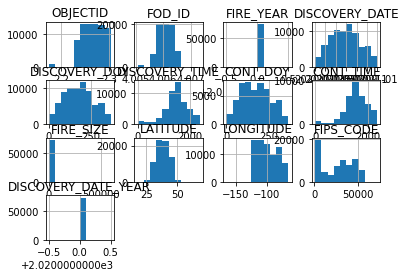

In [13]:
wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020].hist()

<AxesSubplot:xlabel='LONGITUDE', ylabel='LATITUDE'>

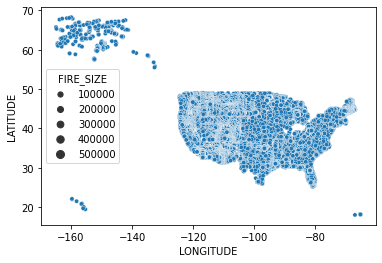

In [14]:
sns.scatterplot(x='LONGITUDE', y='LATITUDE', size='FIRE_SIZE', data=wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020])

In [29]:
wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020].to_csv('data/us-wildfires/data-2020.csv', sep=",", na_values="NA")

TypeError: NDFrame.to_csv() got an unexpected keyword argument 'na_values'

<AxesSubplot:xlabel='CONT_TIME', ylabel='FIRE_SIZE'>

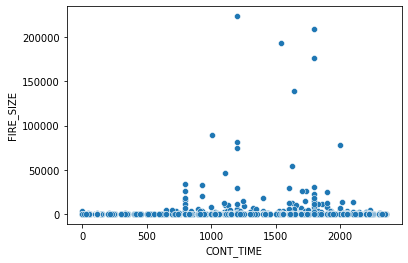

In [16]:
sns.scatterplot(x='CONT_TIME', y='FIRE_SIZE', data=wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020])

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
X = wildfires[wildfires["DISCOVERY_DATE_YEAR"] == 2020]
X = X[['LATITUDE', 'LONGITUDE']]
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

InvalidIndexError: (slice(None, None, None), 0)

In [28]:
#http://archive.ics.uci.edu/ml/datasets/Wine
wines = pd.read_csv('data/wine/wine.data', sep=",", na_values="NA", header=None)
wines

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [27]:
#http://archive.ics.uci.edu/ml/datasets/Wine
wines_quality = pd.read_csv('data/wine-quality/winequality-red.csv', sep=";", na_values="NA")
wines_quality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
